# Write an intro

In [1]:
# python3 -m venv data_analysis_env
!source data_analysis_env/bin/activate
%pip install -r requirements.txt


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


# Set seaborn style and color palette
sns.set_style("darkgrid")  
sns.set_palette(sns.color_palette("Spectral"))

# Load the data
df = pd.read_csv('data/online_retail_clean.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541797 entries, 0 to 541796
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541797 non-null  object 
 1   StockCode    541797 non-null  object 
 2   Description  541797 non-null  object 
 3   Quantity     541797 non-null  int64  
 4   InvoiceDate  541797 non-null  object 
 5   UnitPrice    541797 non-null  float64
 6   CustomerID   541797 non-null  int64  
 7   Country      541797 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 33.1+ MB


In [4]:
# Convert the InvoiceDate column to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Define a function that will parse the date
def get_month(InvoiceDate):
    return dt.datetime(InvoiceDate.year, InvoiceDate.month, 1)

# Apply the function to the InvoiceDate column
df['Month'] = df['InvoiceDate'].apply(get_month)

monthly_active_customers = df.groupby('CustomerID')['Month']
df['CohortMonth'] = monthly_active_customers.transform('min')
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01


In [5]:
# Calculating the time offset
def get_integer_values_date(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

invoice_year, invoice_month, _ = get_integer_values_date(df, 'Month')
cohort_year, cohort_month, _ = get_integer_values_date(df, 'CohortMonth')

years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month

df['CohortIndex'] = years_diff * 12 + months_diff + 1
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01,2010-12-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,1


In [6]:
# Count monthly active customers from each cohort
grouping = df.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique).reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth',
                                    columns='CohortIndex',
                                    values='CustomerID')

cohort_counts.head()

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,949.0,363.0,318.0,368.0,342.0,377.0,361.0,337.0,337.0,375.0,355.0,475.0,261.0
2011-01-01,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,NaN
2011-02-01,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,NaN,NaN
2011-03-01,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,NaN,NaN,NaN
2011-04-01,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,NaN,NaN,NaN,NaN


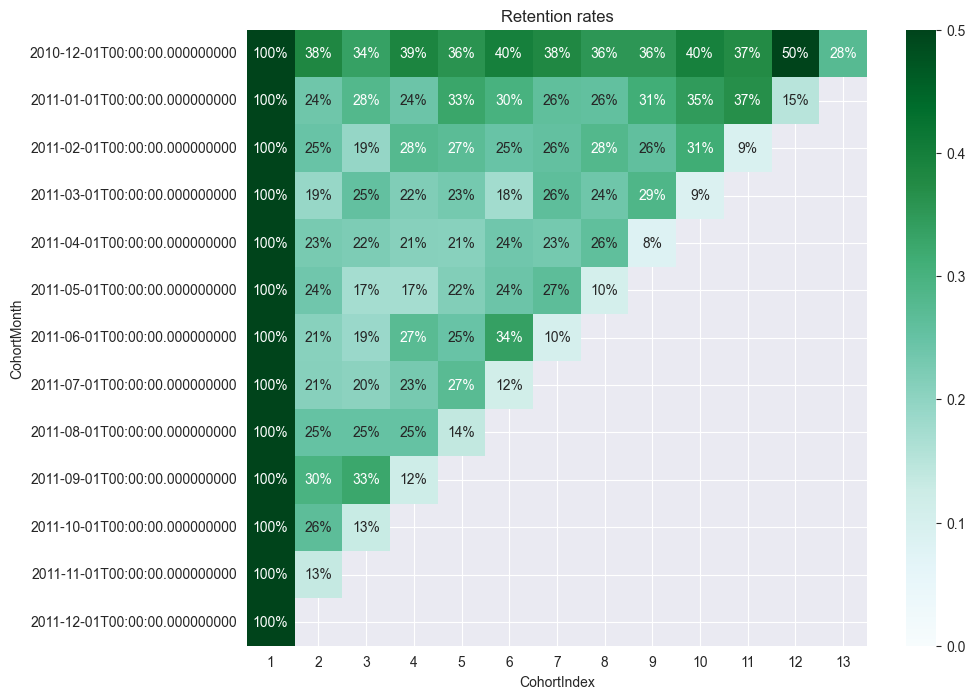

In [7]:
# Calculate Retention Rate
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.round(3) * 100

# Create the heatmap
plt.figure(figsize=(10, 8))
plt.title('Retention rates')
sns.heatmap(data=retention,
            annot=True,
            fmt='.0%',
            vmin=0.0,
            vmax=0.5,
            cmap='BuGn')
plt.show()


# Calculating RFM metrics

In this chapter, we will delve into the process of calculating RFM (Recency, Frequency, Monetary) metrics. RFM analysis is a powerful method used in marketing to evaluate and segment customers based on their purchasing behavior. By analyzing these three metrics, businesses can gain valuable insights into customer loyalty and profitability.

## What is RFM Analysis?

RFM analysis is a customer segmentation technique that uses three quantitative factors:

- **Recency**: How recently a customer made a purchase.
    > Days since last customer transaction.
    > The lower it is the better
- **Frequency**: How often a customer makes a purchase.
    > Number of transaction in the last 12 months.
        >
- **Monetary Value**: How much money a customer spends on purchases.
    > Total money spent in the last 12 months.

## Why Use RFM Analysis?

RFM analysis helps businesses to:

- Identify high-value customers.
- Tailor marketing strategies to different customer segments.
- Improve customer retention by understanding purchasing patterns.
- Increase sales by targeting the right customers with the right offers.

## Steps to Calculate RFM Metrics

1. **Data Preparation**: Clean and preprocess the data to ensure accuracy.
2. **Calculate Recency**: Determine the number of days since the last purchase for each customer.
3. **Calculate Frequency**: Count the total number of purchases made by each customer.
4. **Calculate Monetary Value**: Sum the total amount spent by each customer.
5. **Segment Customers**: Assign scores to each customer based on their RFM values and create segments.

In the following sections, we will walk through each step in detail, using Python and various data analysis libraries to perform RFM analysis on a sample dataset.

In [8]:
# Let's remove guest checkouts from the dataset
# Guest checkouts have CustomerID = -1
df = df[df['CustomerID'] != -1]

# We should also remove returns from the dataset as they are not considered in the analysis
# Returns have InvoiceNo starting with 'C'
df = df[~df['InvoiceNo'].str.contains('C', na=False)]


In [9]:
# Let's create hypothetical snapshot date
snapshot_date = max(df['InvoiceDate']) + dt.timedelta(days=1)
snapshot_date

Timestamp('2011-12-10 12:50:00')

In [10]:
# TotalSum
df['TotalSum'] = df['Quantity'] * df['UnitPrice']

# Calculating RFM metrics
rfm = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
                                    'InvoiceNo': 'count',
                                    'TotalSum': 'sum'})

# Rename the columns
rfm.rename(columns={'InvoiceDate': 'Recency',
                    'InvoiceNo': 'Frequency',
                    'TotalSum': 'MonetaryValue'}, inplace=True)

rfm.head()


,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,326,1,77183.60
12347,2,182,4310.00
12348,75,31,1797.24
12349,19,73,1757.55
12350,310,17,334.40


In [11]:
# ** Assigning Labels to RFM metrics **
# ------------------------- #

# Recency
r_labels = range(4, 0, -1) # The smaller the recency value, the better
f_labels = range(1, 5) # The bigger the frequency value, the better
m_labels = range(1, 5) # The bigger the monetary value, the better

# Calculating the quartile value for each metric
r_quartiles = pd.qcut(rfm['Recency'], 4, labels=r_labels)
f_quartiles = pd.qcut(rfm['Frequency'], 4, labels=f_labels)
m_quartiles = pd.qcut(rfm['MonetaryValue'], 4, labels=m_labels)

# Assigning the quartile values to the RFM table
rfm['F'] = f_quartiles
rfm['R'] = r_quartiles 
rfm['M'] = m_quartiles

# **Building RFM Segments and RFM Score**
# -------------------------------------- #
# Concatenate RFM quartile values to create RFM Segments
def join_rfm(x):
    return str(x['R']) + str(x['F']) + str(x['M'])
rfm['RFM_Segment'] = rfm.apply(join_rfm, axis=1)

# Sum RFM quartiles to create RFM Score
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)

rfm.head()


,Recency,Frequency,MonetaryValue,F,R,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346,326,1,77183.60,1,1,4,1.01.04.0,6
12347,2,182,4310.00,4,4,4,4.04.04.0,12
12348,75,31,1797.24,2,2,4,2.02.04.0,8
12349,19,73,1757.55,3,3,4,3.03.04.0,10
12350,310,17,334.40,1,1,2,1.01.02.0,4


In [12]:
# # Create a classification function
# def classify_segment(row):
#     """
#     Classifies each customer row into a more descriptive segment 
#     based on the R (Recency), F (Frequency), and M (Monetary) quartile values.
    
#     - "Champions":     R=4, F=4, M=4 
#     - "Loyal":         Generally good on Frequency & Recency 
#     - "Big Spender":   High Monetary 
#     - "At Risk":       Low Frequency or Monetary but not worst Recency 
#     - "Hibernating":   Worst Recency, Frequency, or Monetary 
#     - "Others":        Default group if none of the above
#     """
#     R = int(row['R'])
#     F = int(row['F'])
#     M = int(row['M'])
    
#     # "Champions" => top on all three: best recency, freq, and monetary
#     if R == 4 and F == 4 and M == 4:
#         return 'Champions'
    
#     # "Loyal" => good recent engagement and frequency, but not necessarily top spend
#     if R >= 3 and F >= 3:
#         return 'Loyal'
    
#     # "Big Spender" => high monetary, even if recency/frequency aren’t top
#     if M == 4 and (R >= 2 or F >= 2):
#         return 'Big Spender'
    
#     # "At Risk" => not too old but freq or monetary are somewhat low
#     if R >= 2 and (F <= 2 or M <= 2):
#         return 'At Risk'
    
#     # "Hibernating" => worst recency or overall low frequency/monetary
#     if R == 1 or (F == 1 and M == 1):
#         return 'Hibernating'
    
#     # Default segment
#     return 'Others'

# rfm['Segment'] = rfm.apply(classify_segment, axis=1)

# # Visualise the RFM segments distribution
# plt.figure(figsize=(12, 4))
# sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index)
# plt.title('RFM Segments Distribution')
# plt.ylabel('Number of Customers')
# plt.xlabel('Segment')
# plt.xticks(rotation=45)
# plt.show()

# # Drop the RFM_Segment column
# rfm.drop('RFM_Segment', axis=1, inplace=True)
    

# Data Preprocessing.

### Key K-Means assumptions 
- Symmetric distribution of variables (now skewed)
- Variables with the same average values
- Variables with the same variance

Here are three key assumptions of the K-Means algorithm:

1. **Cluster Shape**: K-Means assumes that clusters are spherical and evenly sized. This means that the algorithm works best when the clusters are roughly circular (or spherical in higher dimensions) and have similar sizes. If the clusters have irregular shapes or vary significantly in size, K-Means may not perform well.

2. **Cluster Independence**: K-Means assumes that the clusters are independent of each other. This means that the presence of one cluster does not affect the formation of another cluster. Each cluster is treated as a separate entity.

3. **Feature Scaling**: K-Means assumes that the features are scaled properly. Since K-Means uses Euclidean distance to assign points to clusters, it is sensitive to the scale of the features. Features with larger scales can dominate the distance calculation, leading to biased clustering results. Therefore, it is important to standardize or normalize the features before applying K-Means.

# Pipeline Sequence:
-> Unskew the data - use log >
Normalise the variables - use sklearn >
Store for clustering 

In [13]:
rfm.head()

,Recency,Frequency,MonetaryValue,F,R,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346,326,1,77183.60,1,1,4,1.01.04.0,6
12347,2,182,4310.00,4,4,4,4.04.04.0,12
12348,75,31,1797.24,2,2,4,2.02.04.0,8
12349,19,73,1757.55,3,3,4,3.03.04.0,10
12350,310,17,334.40,1,1,2,1.01.02.0,4


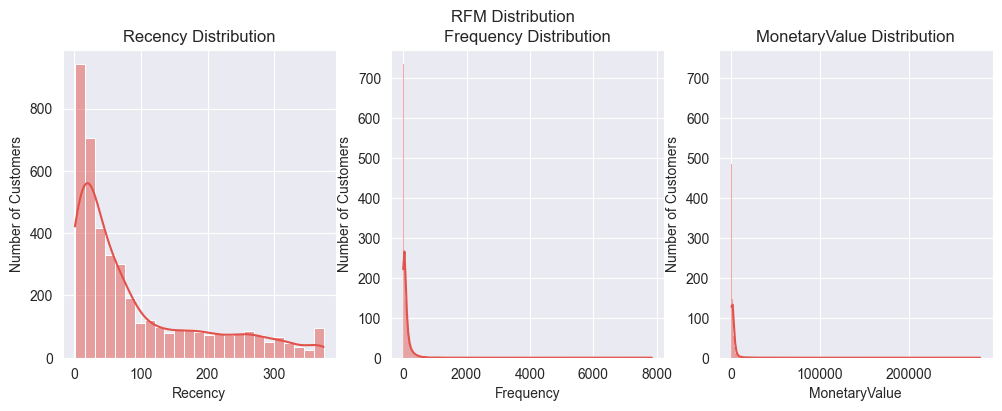

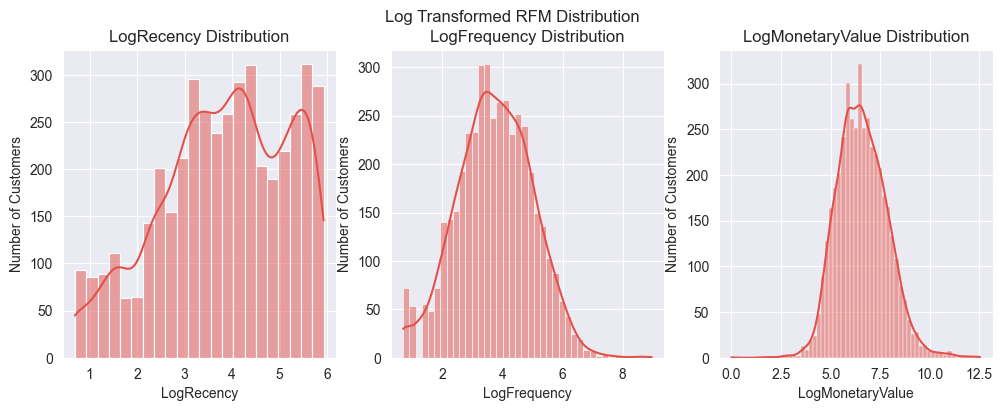

In [14]:
# ** Normalising RFM skewness **
# ------------------------- #

# Visualise the RFM distribution
subplots = ['Recency', 'Frequency', 'MonetaryValue']
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle('RFM Distribution')

for i, subplot in enumerate(subplots):
    sns.histplot(rfm[subplot], kde=True, ax=axes[i])
    axes[i].set_title(f'{subplot} Distribution')
    axes[i].set_ylabel('Number of Customers')
    axes[i].set_xlabel(subplot)
plt.show()

# All 3 variables are skewed to the right
# Let's apply log transformation to reduce the skewness
rfm_log = np.log1p(rfm[['Recency', 'Frequency', 'MonetaryValue']])
rfm_log.columns = ['LogRecency', 'LogFrequency', 'LogMonetaryValue']

# Visualise the log transformed RFM distribution
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle('Log Transformed RFM Distribution')

for i, subplot in enumerate(rfm_log.columns):
    sns.histplot(rfm_log[subplot], kde=True, ax=axes[i])
    axes[i].set_title(f'{subplot} Distribution')
    axes[i].set_ylabel('Number of Customers')
    axes[i].set_xlabel(subplot)
plt.show()

    

### Identifying the issue.


In [15]:
rfm.describe()

,Recency,Frequency,MonetaryValue,RFM_Score
count,4339.000000,4339.000000,4339.000000,4339.000000
mean,92.518322,91.708689,2053.793018,7.504955
std,100.009747,228.792852,8988.248381,2.816529
min,1.000000,1.000000,0.000000,3.000000
25%,18.000000,17.000000,307.245000,5.000000
50%,51.000000,41.000000,674.450000,7.000000
75%,142.000000,100.000000,1661.640000,10.000000
max,374.000000,7847.000000,280206.020000,12.000000


In [16]:
# # Manual standardization of the data
# rfm_standardized = rfm_log.copy()

# # Calculate the mean and standard deviation for each column
# mean_log_recency = rfm_standardized['LogRecency'].mean()
# std_log_recency = rfm_standardized['LogRecency'].std()

# mean_log_frequency = rfm_standardized['LogFrequency'].mean()
# std_log_frequency = rfm_standardized['LogFrequency'].std()

# mean_log_monetary_value = rfm_standardized['LogMonetaryValue'].mean()
# std_log_monetary_value = rfm_standardized['LogMonetaryValue'].std()

# # Standardize each column
# rfm_standardized['LogRecency'] = (rfm_standardized['LogRecency'] - mean_log_recency) / std_log_recency
# rfm_standardized['LogFrequency'] = (rfm_standardized['LogFrequency'] - mean_log_frequency) / std_log_frequency
# rfm_standardized['LogMonetaryValue'] = (rfm_standardized['LogMonetaryValue'] - mean_log_monetary_value) / std_log_monetary_value

# rfm_standardized.head()

In [17]:
# ** Standardising RFM **
# K-Means works well with variables with the same mean and variance
# Let's standardise the RFM variables
# ------------------------- #

# Standardise the log transformed RFM values
scaler = StandardScaler()

rfm_standardised = rfm_log.copy()
rfm_standardised = scaler.fit_transform(rfm_standardised)
print(f'Mean: {rfm_standardised.mean(axis=0).round(2)}')
print(f'Standard Deviation: {rfm_standardised.std(axis=0).round(2)}')

Mean: [ 0. -0.  0.]
Standard Deviation: [1. 1. 1.]


# K-Means Clustering Plan

## Objective
To segment customers based on their purchasing behavior using K-Means clustering.

## Steps

1. **Determine Optimal Number of Clusters**:
    - Use the elbow method to visualize the inertia for different numbers of clusters.
    - Plot the elbow curve to identify the optimal number of clusters.

2. **Fit K-Means Model**:
    - Initialize the K-Means model with the optimal number of clusters.
    - Fit the model to the standardized RFM data.

3. **Assign Cluster Labels**:
    - Predict the cluster for each customer.
    - Assign the cluster labels to the original RFM data.

4. **Analyze Clusters**:
    - Calculate the sum of squared errors (SSE) to evaluate the model.
    - Visualize the clusters using a snake plot to understand the characteristics of each cluster.

5. **Interpret Results**:
    - Interpret the clusters to gain insights into customer segments.
    - Use the insights to inform marketing strategies and improve customer engagement.

In [18]:
# # ** K-Means Clustering Example **
# # ------------------------- #

# from sklearn.cluster import KMeans
# kmeans = KMeans(n_clusters=4, random_state=1)
# kmeans.fit(rfm_standardised)

# # Create a cluster label column in the original dataset
# rfm['Cluster'] = kmeans.labels_

# # Calculate the mean value for each cluster
# cluster_avg = rfm.groupby('Cluster').agg({
#     'Recency': 'mean',
#     'Frequency': 'mean',
#     'MonetaryValue': 'mean',
#     'Segment': lambda x: x.value_counts().index[0]
# }).round(0)

# cluster_avg.head()


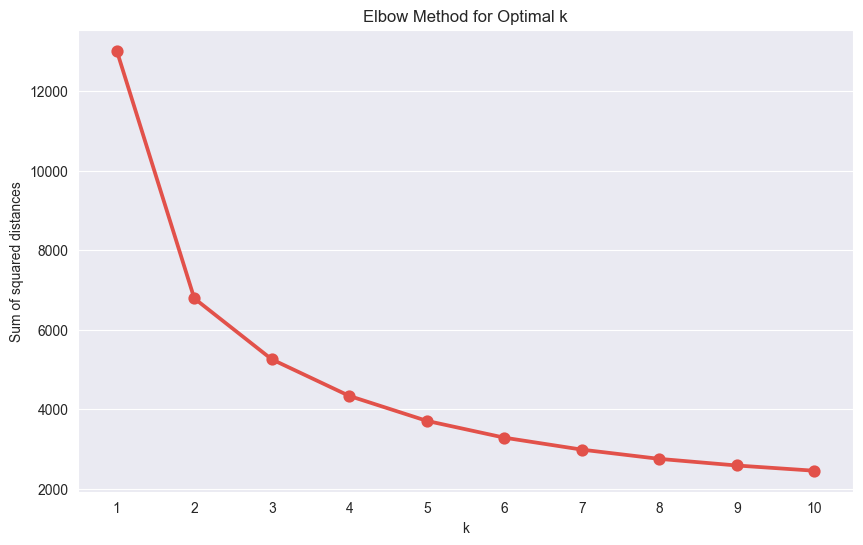

In [19]:
# # ** K-Means Clustering ** #
# -------------------------- #

# First use the Elbow Method to determine the optimal number of clusters
# We will use the sum of squared distances to determine the optimal number of clusters
# We will plot the sum of squared distances for different values of k
# The 'elbow' in the plot is the optimal number of clusters
# The sum of squared distances decreases as the number of clusters increases
# The 'elbow' is the point where the rate of decrease sharply changes
# This is the optimal number of clusters

# Calculate the sum of squared distances for different values of k
ssd = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(rfm_standardised)
    ssd.append(kmeans.inertia_)

# Plot the sum of squared distances for different values of k
plt.figure(figsize=(10, 6))
sns.pointplot(x=K, y=ssd)
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method for Optimal k')
plt.show()



In [32]:
# Perform K-Means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(rfm_standardised)

# Create a cluster label column in the original dataset
rfm['Cluster'] = kmeans.labels_

# Calculate the mean value for each cluster
cluster_avg = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean'
}).round(0)

cluster_avg.head()


,Recency,Frequency,MonetaryValue
Cluster,,,
0,179.0,15.0,298.0
1,14.0,294.0,7399.0
2,62.0,66.0,1172.0


## Customer Segmentation Using K-Means  

The elbow method suggests that **2 clusters** might be the best option based on the sum of squared distances. However, choosing the number of clusters depends on business goals. In this case, segmenting customers into **3 clusters** provides more insights into different customer behaviors.  

### Interpretation of Clusters  

#### **2-Cluster Model**
- **Cluster 0 ("At Risk")**: Customers who haven't purchased recently, buy less frequently, and have a lower monetary value.  
- **Cluster 1 ("Loyal")**: Customers who purchase often, have high spending, and return frequently.  

While this segmentation is useful, it may oversimplify customer diversity.  

#### **3-Cluster Model**
- **Cluster 0 ("Hibernating")**: Customers who haven't purchased in a long time, shop infrequently, and contribute low revenue.  
- **Cluster 1 ("Loyal")**: Highly engaged customers with frequent purchases and high spending.  
- **Cluster 2 ("At Risk")**: Customers who were once active but are now showing signs of reduced engagement.  

This segmentation provides a more detailed view, allowing businesses to create targeted marketing strategies:  
- **Re-engagement campaigns** for "Hibernating" customers.  
- **Retention strategies** for "At Risk" customers.  
- **Exclusive offers or loyalty rewards** for "Loyal" customers.  

Choosing the right number of clusters is a trade-off between simplicity and actionable insights. In this case, a 3-cluster model gives a more detailed understanding of customer behavior.  


/var/folders/xh/x6c57wpx5hv7g4hxw7y4c6cc0000gn/T/ipykernel_17153/3848451566.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=rfm_melt, x='Attribute', y='Value', hue='Cluster', ci='sd')


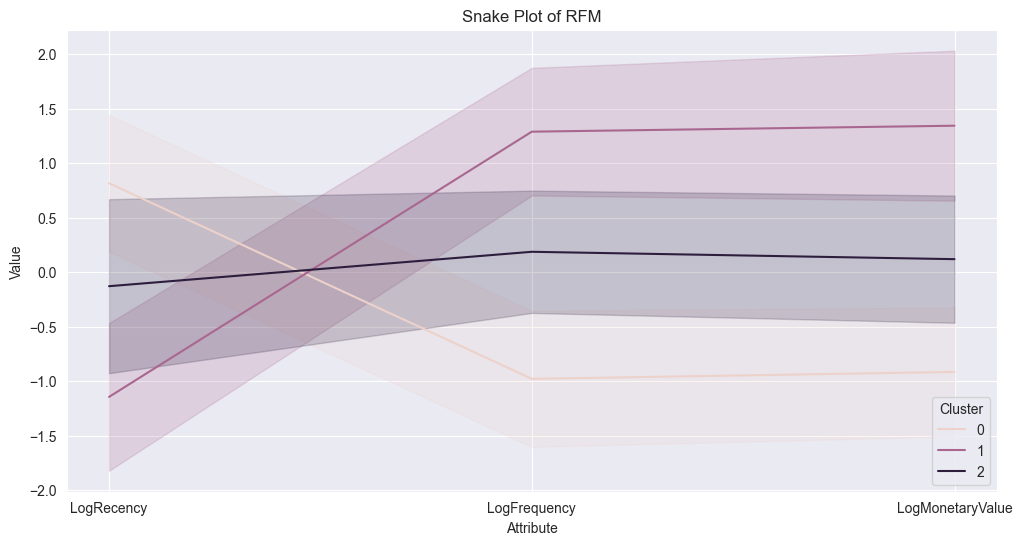

In [33]:
# # ** Snake Plot **
# # ** Prepare the data for the snake plot **
# # ------------------------- #

# Transform the standardized data into a DataFrame
rfm_standardised = pd.DataFrame(rfm_standardised, index=rfm.index, columns=['LogRecency', 'LogFrequency', 'LogMonetaryValue'])

# Add the cluster label to the DataFrame
rfm_standardised['Cluster'] = kmeans.labels_

# Melt the data into a long format
rfm_melt = pd.melt(rfm_standardised.reset_index(), id_vars=['CustomerID', 'Cluster'],
                   value_vars=['LogRecency', 'LogFrequency', 'LogMonetaryValue'],
                   var_name='Attribute',
                   value_name='Value')

# # ** Visualise the snake plot **
# # ------------------------- #

# Create a snake plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=rfm_melt, x='Attribute', y='Value', hue='Cluster', ci='sd')
plt.title('Snake Plot of RFM')
plt.ylabel('Value')
plt.xlabel('Attribute')
plt.show()


**Cluster 0:**
- Highest (least recent) Recency, lowest Frequency, lowest Monetary.
    - These customers are the least engaged and contribute the least revenue.
    
**Cluster 1:**
- Lowest (most recent) Recency, highest Frequency, highest Monetary.
    - These are your most active and valuable customers.

**Cluster 2:**
- Moderate Recency, Frequency, and Monetary.
    - These customers are middle-tier in engagement and spend.


Overall Silhouette Score: 0.462


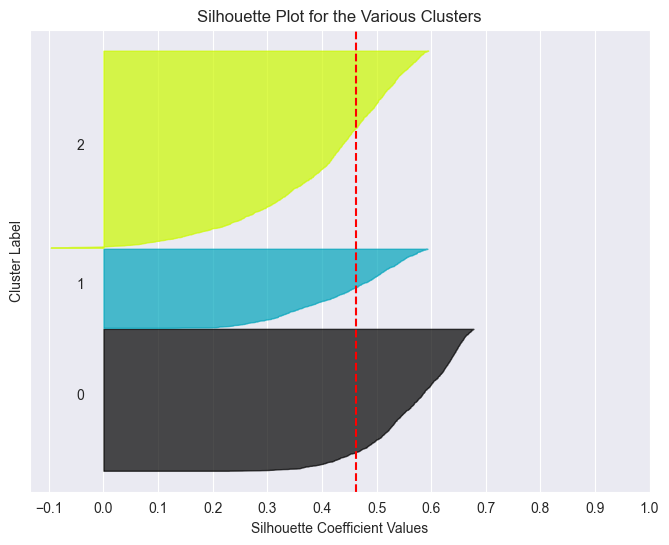

In [34]:
# ------------------------------------------- #
# ** Validate Clusters with silhouette score **
# ------------------------------------------- #

from sklearn.metrics import silhouette_score, silhouette_samples

# Calculate the silhouette score
silhouette_score(rfm_standardised, kmeans.labels_)
silhouette_score(rfm_standardised, kmeans.labels_, metric='euclidean')

# ---------------------------------- #
# ** Visualise the silhouette score **
# ---------------------------------- #
# 5.1 Calculate overall silhouette score
overall_silhouette = silhouette_score(rfm_standardised, kmeans.labels_)
print(f'Overall Silhouette Score: {overall_silhouette:.3f}')

# 5.2 Calculate silhouette scores for each sample
sample_silhouette_values = silhouette_samples(rfm_standardised, kmeans.labels_)

# Optionally, you can plot a Silhouette Analysis chart:
fig, ax = plt.subplots(figsize=(8, 6))
y_lower = 10
for i in range(kmeans.n_clusters):
    # Aggregate silhouette scores for samples in cluster i
    ith_cluster_silhouette_values = sample_silhouette_values[kmeans.labels_ == i]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.nipy_spectral(float(i) / kmeans.n_clusters)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                     0, ith_cluster_silhouette_values,
                     facecolor=color, edgecolor=color, alpha=0.7)
    
    # Label the silhouette plots with their cluster numbers
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # 10 for the 0 samples gap

ax.set_title("Silhouette Plot for the Various Clusters")
ax.set_xlabel("Silhouette Coefficient Values")
ax.set_ylabel("Cluster Label")

# The vertical line for average silhouette score of all values
ax.axvline(x=overall_silhouette, color="red", linestyle="--")

ax.set_yticks([])  # Clear the y-axis labels / ticks
ax.set_xticks([i/10 for i in range(-1, 11)])
plt.show()




---
